In [1]:
## 一般設定

verbose   = False
save_data = True

## 分野の設定
domains = { 'medical'    : True,
            'mce'        : False,
            'economic'   : True,
            'juridical'  : True,
            'publishing' : True }

target_vars = ['word']
target_vars.extend(domains.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k:v for k,v in domains.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## domain count balancing
balanced = True
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing']
selected domains: ['medical', 'economic', 'juridical', 'publishing']
domain balancing: True


In [2]:
### LDA

##
import random
random.seed(12345)

## doc, term の設定
doc_type           = 'word'
term_size          = 'character'
term_types         = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram' ]
term_type          = term_types[0]
ngram_is_inclusive = True
max_doc_length     = 12

## n_topics
n_topics = 20

## DTM 濾過のための設定
minfreq_val = 3 # 3は多過ぎる？skippy とnon-skippy の差が消失するようだ．
abuse_threshold_val = 0.03

In [3]:
## colormap
colormap =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'wheat' ]
for d, c in zip(domains, colormap):
    print(f"分野 {d}".ljust(16) + ": " + f"色 {c}")

分野 medical      : 色 deeppink
分野 mce          : 色 pink
分野 economic     : 色 orange
分野 juridical    : 色 green
分野 publishing   : 色 paleturquoise


In [4]:
import sys, os, copy, pickle
import numpy as np
import pandas as pd

In [5]:
## 保存してあるデータの読み込み
target_dir = "saves"
files = [ f for f in os.listdir(target_dir) if f.endswith(".p") or f.endswith(".dump") ]
#print(files)
#target_file = files[-3] # selects a target file
#target_file = "mixed-terms-filtered-2023-12-20-17.p"
target_file = "mixed-terms-filtered-2024-01-03-15.p" # publishing x sampled=1
print(f"target file: {target_file}")
target_file_name = os.path.join(target_dir, target_file)

target file: mixed-terms-filtered-2024-01-03-15.p


In [6]:
## Pandas を使って .csv ファイルを開くと実は面倒
#import pandas as pd
#df = pd.read_csv(target_file_name, quotechar='"') ## pandas.csv_read(..) opens a file directly
#df

In [7]:
import pandas as pd
import pickle
with open(target_file_name, 'rb') as pickled:
    df = pickle.load(pickled)
df

word  medical  mce  economic  juridical  publishing  domain  \
727          審問      0.0  0.0       0.0        1.0         0.0       3   
332         後頭葉      1.0  0.0       0.0        0.0         0.0       0   
435        ISBN      0.0  0.0       0.0        0.0         1.0       4   
1224       腸管癒着      1.0  0.0       0.0        0.0         0.0       0   
577        前方脱臼      1.0  0.0       0.0        0.0         0.0       0   
...         ...      ...  ...       ...        ...         ...     ...   
68          婚姻届      0.0  0.0       0.0        1.0         0.0       3   
103   ジャパンバッシング      0.0  0.0       1.0        0.0         0.0       2   
1307       胸骨挫傷      1.0  0.0       0.0        0.0         0.0       0   
2279      麻痺性歩行      1.0  0.0       0.0        0.0         0.0       0   
154         買掛金      0.0  0.0       0.0        1.0         0.0       3   

                            1gram  \
727                        [審, 問]   
332                     [後, 頭, 葉]   
435                  [I, S, B, N]   
1224                 [腸, 管, 癒, 着]   
577                  [前, 方, 脱, 臼]   
...                           ...   
68                      [婚, 姻, 届]   
103   [ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]   
1307                 [胸, 骨, 挫, 傷]   
2279              [麻, 痺, 性, 歩, 行]   
154                     [買, 掛, 金]   

                                                  2gram  \
727                                          [審問, 審, 問]   
332                                   [後頭, 頭葉, 後, 頭, 葉]   
435                            [IS, SB, BN, I, S, B, N]   
1224                           [腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                            [前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                                    [婚姻, 姻届, 婚, 姻, 届]   
103   [ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...   
1307                           [胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279                    [麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                                   [買掛, 掛金, 買, 掛, 金]   

                                                  3gram  \
727                                      [審問, 審問, 審, 問]   
332                              [後頭葉, 後頭, 頭葉, 後, 頭, 葉]   
435                  [ISB, SBN, IS, SB, BN, I, S, B, N]   
1224                 [腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                  [前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻届, 婚姻, 姻届, 婚, 姻, 届]   
103   [ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...   
1307                 [胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279     [麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                              [買掛金, 買掛, 掛金, 買, 掛, 金]   

                                            skippy2gram  \
727                                          [審問, 審, 問]   
332                              [後頭, 後…葉, 頭葉, 後, 頭, 葉]   
435             [IS, I…B, I…N, SB, S…N, BN, I, S, B, N]   
1224            [腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]   
577             [前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻, 婚…届, 姻届, 婚, 姻, 届]   
103   [ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...   
1307            [胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]   
2279  [麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...   
154                              [買掛, 買…金, 掛金, 買, 掛, 金]   

                                            skippy3gram  
727                                      [審問, 審問, 審, 問]  
332                         [後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]  
435   [ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ...  
1224  [腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ...  
577   [前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ...  
...                                                 ...  
68                          [婚姻届, 婚姻, 婚…届, 姻届, 婚, 姻, 届]  
103   [ジャパ, ジャ…ン, ジャ…バ, ジャ…ッ, ジャ…シ, ジャ…グ, ジ…パン, ジ…パ…...  
1307  [胸骨挫, 胸骨…傷, 胸…挫傷, 骨挫傷,

In [8]:
## 列名 domain を変更し，文字列としての domain を追加
df = df.rename(columns = {'domain': 'domain_id'})
df['domain'] = [ list(domains.keys())[i] for i in df['domain_id'] ]
df

word  medical  mce  economic  juridical  publishing  domain_id  \
727          審問      0.0  0.0       0.0        1.0         0.0          3   
332         後頭葉      1.0  0.0       0.0        0.0         0.0          0   
435        ISBN      0.0  0.0       0.0        0.0         1.0          4   
1224       腸管癒着      1.0  0.0       0.0        0.0         0.0          0   
577        前方脱臼      1.0  0.0       0.0        0.0         0.0          0   
...         ...      ...  ...       ...        ...         ...        ...   
68          婚姻届      0.0  0.0       0.0        1.0         0.0          3   
103   ジャパンバッシング      0.0  0.0       1.0        0.0         0.0          2   
1307       胸骨挫傷      1.0  0.0       0.0        0.0         0.0          0   
2279      麻痺性歩行      1.0  0.0       0.0        0.0         0.0          0   
154         買掛金      0.0  0.0       0.0        1.0         0.0          3   

                            1gram  \
727                        [審, 問]   
332                     [後, 頭, 葉]   
435                  [I, S, B, N]   
1224                 [腸, 管, 癒, 着]   
577                  [前, 方, 脱, 臼]   
...                           ...   
68                      [婚, 姻, 届]   
103   [ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]   
1307                 [胸, 骨, 挫, 傷]   
2279              [麻, 痺, 性, 歩, 行]   
154                     [買, 掛, 金]   

                                                  2gram  \
727                                          [審問, 審, 問]   
332                                   [後頭, 頭葉, 後, 頭, 葉]   
435                            [IS, SB, BN, I, S, B, N]   
1224                           [腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                            [前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                                    [婚姻, 姻届, 婚, 姻, 届]   
103   [ジャ, ャパ, パン, ンバ, バッ, ッシ, シン, ング, ジ, ャ, パ, ン, バ...   
1307                           [胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279                    [麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                                   [買掛, 掛金, 買, 掛, 金]   

                                                  3gram  \
727                                      [審問, 審問, 審, 問]   
332                              [後頭葉, 後頭, 頭葉, 後, 頭, 葉]   
435                  [ISB, SBN, IS, SB, BN, I, S, B, N]   
1224                 [腸管癒, 管癒着, 腸管, 管癒, 癒着, 腸, 管, 癒, 着]   
577                  [前方脱, 方脱臼, 前方, 方脱, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻届, 婚姻, 姻届, 婚, 姻, 届]   
103   [ジャパ, ャパン, パンバ, ンバッ, バッシ, ッシン, シング, ジャ, ャパ, パン...   
1307                 [胸骨挫, 骨挫傷, 胸骨, 骨挫, 挫傷, 胸, 骨, 挫, 傷]   
2279     [麻痺性, 痺性歩, 性歩行, 麻痺, 痺性, 性歩, 歩行, 麻, 痺, 性, 歩, 行]   
154                              [買掛金, 買掛, 掛金, 買, 掛, 金]   

                                            skippy2gram  \
727                                          [審問, 審, 問]   
332                              [後頭, 後…葉, 頭葉, 後, 頭, 葉]   
435             [IS, I…B, I…N, SB, S…N, BN, I, S, B, N]   
1224            [腸管, 腸…癒, 腸…着, 管癒, 管…着, 癒着, 腸, 管, 癒, 着]   
577             [前方, 前…脱, 前…臼, 方脱, 方…臼, 脱臼, 前, 方, 脱, 臼]   
...                                                 ...   
68                               [婚姻, 婚…届, 姻届, 婚, 姻, 届]   
103   [ジャ, ジ…パ, ジ…ン, ジ…バ, ジ…ッ, ジ…シ, ジ…グ, ャパ, ャ…ン, ャ…...   
1307            [胸骨, 胸…挫, 胸…傷, 骨挫, 骨…傷, 挫傷, 胸, 骨, 挫, 傷]   
2279  [麻痺, 麻…性, 麻…歩, 麻…行, 痺性, 痺…歩, 痺…行, 性歩, 性…行, 歩行,...   
154                              [買掛, 買…金, 掛金, 買, 掛, 金]   

                                            skippy3gram      domain  
727                                      [審問, 審問, 審, 問]   juridical  
332                         [後頭葉, 後頭, 後…葉, 頭葉, 後, 頭, 葉]     medical  
435   [ISB, IS…N, I…BN, SBN, IS, I…B, I…N, SB, S…N, ...  publishing  
1224  [腸管癒, 腸管…着, 腸…癒着, 管癒着, 腸管, 腸…癒, 腸…着, 管癒, 管…着, ...     medical  
577   [前方脱, 前方…臼, 前…脱臼, 方脱臼, 前方, 前…脱, 前…臼, 方脱, 方…臼, ...     medical  
...                                                 ...         ...  
68                      

In [9]:
## LDA
bots = df[term_type] # bot = bag-of-terms
bots

727                          [審, 問]
332                       [後, 頭, 葉]
435                    [I, S, B, N]
1224                   [腸, 管, 癒, 着]
577                    [前, 方, 脱, 臼]
                   ...             
68                        [婚, 姻, 届]
103     [ジ, ャ, パ, ン, バ, ッ, シ, ン, グ]
1307                   [胸, 骨, 挫, 傷]
2279                [麻, 痺, 性, 歩, 行]
154                       [買, 掛, 金]
Name: 1gram, Length: 1997, dtype: object

In [10]:
## dtm を構築
from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<1261 unique tokens: ['問', '審', '後', '葉', '頭']...>


In [11]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction) # 予備の生成

## 対象とする語の最低頻度: documents の数が少ない場合は小さくても良い
print(f"minfreq_val: {minfreq_val}")

## 過剰使用 term の濾過
print(f"abuse_threshold_val: {abuse_threshold_val}")

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq_val, no_above = abuse_threshold_val)

## check
print(diction_copy) # 中身を見るには print(..) が必要

minfreq_val: 3
abuse_threshold_val: 0.03
Dictionary<743 unique tokens: ['問', '審', '後', '葉', '頭']...>


In [12]:
### gensim の用 corpusの構築

## データを選択
diction = diction_copy # 名前を元に戻す

## corpus構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
print(f"Number of documents: {len(corpus)}")

Number of documents: 1997


In [13]:
## LDA モデルの構築
from gensim.models import LdaModel

## LDAモデル
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(lda) # 中身を見るには print(..) が必要

LdaModel<num_terms=743, num_topics=20, decay=0.5, chunksize=2000>


In [14]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
#
n_terms = 20 # topic ごとに表示する term 数の指定
#
import pandas as pd
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

topic 1 topic 2 topic 3 topic 4 topic 5 topic 6 topic 7 topic 8 topic 9  \
0        フ       ル       イ       行       会       判       債       権       本   
1        シ       血       ロ       動       折       保       シ       行       産   
2        傷       格       バ       業       I       結       ミ       業       内   
3        チ       炎       ブ       定       人       法       紙       法       症   
4        理       合       紙       ブ       金       紙       裂       フ       法   
5        ラ       金       ク       反       傷       傷       き       制       リ   
6        ロ       出       血       リ       損       付       務       銀       裁   
7        キ       カ       出       転       理       事       分       質       ク   
8        ュ       腸       ・       ク       S       決       財       亜       経   
9        表       社       ド       索       場       ん       不       P       行   
10       紙       価       ラ       分       管       介       な       事       権   
11       人       表       腫       頭       特       護       損       務       生   
12       代       会       フ       規       市       経       人       同       済   
13       挫       腫       発       背       融       機       上       共       入   
14       ョ       瘍       入       キ       紙       問       団       農       所   
15       ク       判       式       書       判       て       間       国       国   
16       プ       タ       外       管       腎       腸       貼       B       ル   
17       腫       グ       耳       B       法       害       機       資       出   
18       イ       ダ       公       開       炎       後       業       為       金   
19       コ       事       機       気       取       間       切       T       無   

   topic 10 topic 11 topic 12 topic 13 topic 14 topic 15 topic 16 topic 17  \
0         資        症        商        炎        腫        産        行        中   
1         経        本        腫        ク        ア        金        生        テ   
2         主        者        炎        リ        瘍        理        合        判   
3         本        遺        業        動        務        合        国        解   
4         義        金        産        イ        事        掛        養        ル   
5         ア        公        人        脈        機        方        児        機   
6         済        伝        証        ラ        公        長        為        シ   
7         国        働        瘍        デ        炎        人        紙        タ   
8         占        物        法        機        膜        機        価        審   
9         業        務        情        ル        骨        保        施        耳   
10        ュ        M        大        ロ        手        け        設        整   
11        C        デ        体        膜        紙        生        コ        手   
12        最        炎        金        綴        ル        コ        傷        熱   
13        転        ム        感        引        議        財        入        ク   
14        規        フ        外        聴        シ        団        外        時   
15        麻        紙        頭        皮        債        瘍        親        業   
16        日        済        協        結        レ        ア        ア        分   
17        状        ク        券        業        髄        経        議        溝   
18        者        A        部        ブ        国        腫        裂        先   
19        分        業        報        取        会        紙        力        持   

   topic 18 topic 19 topic 20  
0         請        判        立  
1         求        裁        書  
2         発        ラ        権  
3         産        イ        機  
4         部        バ        会  
5         ア        ル        傷  
6         不        グ        症  
7         資        表        丁  
8         中        み        金  
9         瘍        ク        紙  
10        ル        し        株  
11        腫        婚        本  
12        ク        革        国  
13        膜        紙        付  
14        度        日        装  
15        制        ボ        約  
16        P        角        行  
17        イ        刷        制  
18        毒        者        際  
19        タ        ネ        人

In [15]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい

import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [16]:
## doc のエンコード
check = False
encoding = [ ]
print(f"term_type: {term_type}")
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check: print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

term_type: 1gram


1997

In [17]:
## df に encoding の列を追加: tuple なので map(..) が必要
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if check:
    df

# t-SNE を使った可視化

In [18]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)

import sklearn.manifold
import numpy as np
import pandas as pd
import plotly.express as pex

## perplexity の効果を確認
divider = 4
relative_perplexity = True
if relative_perplexity:
    max_val = round(len(df)/divider)
else:
    max_val = 200
perplexity_vals = range(5, max_val, 50) # 10から始めて doc数の 1/divider まで，50づつ大きくする
print(f"perplexity vals: {perplexity_vals}")

E = np.array(list(df['enc']))
for perplexity_val in perplexity_vals:
    ## tSNE 3D の生成
    tSNE_3d_varied = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = perplexity_val, n_iter = 1000)
    ## Fitting
    model_fitted = tSNE_3d_varied.fit_transform(E)
    
    ## df の編集
    df['tSNE_d1'] = model_fitted[:,0]
    df['tSNE_d2'] = model_fitted[:,1]
    df['tSNE_d3'] = model_fitted[:,2]
    
    ## 描画
    title_val = f"tSNE 3D map (perplexity: {perplexity_val}) for {term_type}-based LDA ({n_topics} topics)"
    fig = pex.scatter_3d(df, x = 'tSNE_d1', y = 'tSNE_d2', z = 'tSNE_d3',
                                     color = 'domain', title = title_val)
    #
    fig.update_layout(showlegend = True, legend = {'itemsizing': 'constant'},
                  autosize = False, width = 600, height = 600)
    fig.update_traces(marker_size = 5)
    fig.show()

# 階層クラスタリング

In [19]:
## 階層クラスタリングのための事例サンプリング

import os, pickle

## データの再利用のための設定
target_dir = "saves"
signature  = "hc-df-sampled-"
        
## サンプリング処理

reload_df_sampled = True
save_a_new_df     = False

## df-sampled.p の最新の版を選ぶ
target_p_fname = [ f for f in [ f for f in os.listdir(target_dir)
                               if signature in str(f) ] if f.endswith(".p") or f.endswith(".dump") ][-1]
print(f"target_p_fname: {target_p_fname}")

target_p_fpath = os.path.join(target_dir, target_p_fname)
with open(target_p_fpath, 'rb') as data:
    print(f"loading pickle: {target_p_fpath}")
    df_sampled_reloaded = pickle.load(data)

##
df_size = len(df)
hc_sampling_rate = 0.1 # 変更可能: 大きくし過ぎると図が見にくい

if reload_df_sampled:
    df_sampled = df_sampled_reloaded
else:
    df_sampled = df.sample(round(df_size * hc_sampling_rate))
    ## 保存
    if save_a_new_df:
        import datetime as dt
        ct = dt.datetime.now()
        ## Pandas で .csv として
        hc_sample_fn1 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".csv"
        hc_sample_fn2 = f"{target_dir}/{signature}{ct.date()}-{str(ct.time())[:2]}" + ".p"

        ## reload 用に保存
        import pandas as pd
        df_sampled.to_csv(hc_sample_fn1)
        print(f"saving data to {hc_sample_fn1}")

        ## pickle.dump(..)で
        import pickle
        print(f"saving data to {hc_sample_fn2}")
        with open(hc_sample_fn2, "wb") as f:
            pickle.dump(df_sampled, f)

##
print(f"{len(df_sampled)} rows are sampled (preservation rate: {len(df_sampled)/df_size})")

## domain 事例数の確認
df_sampled['domain'].value_counts()

target_p_fname: hc-df-sampled-2024-01-08-18.p
loading pickle: saves/hc-df-sampled-2024-01-08-18.p
200 rows are sampled (preservation rate: 0.100150225338007)


domain
juridical     55
publishing    53
medical       52
economic      40
Name: count, dtype: int64

/var/folders/yh/c68mhtcj6yn7qsl201kw_7zw0000gn/T/ipykernel_36295/3789784138.py:34: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



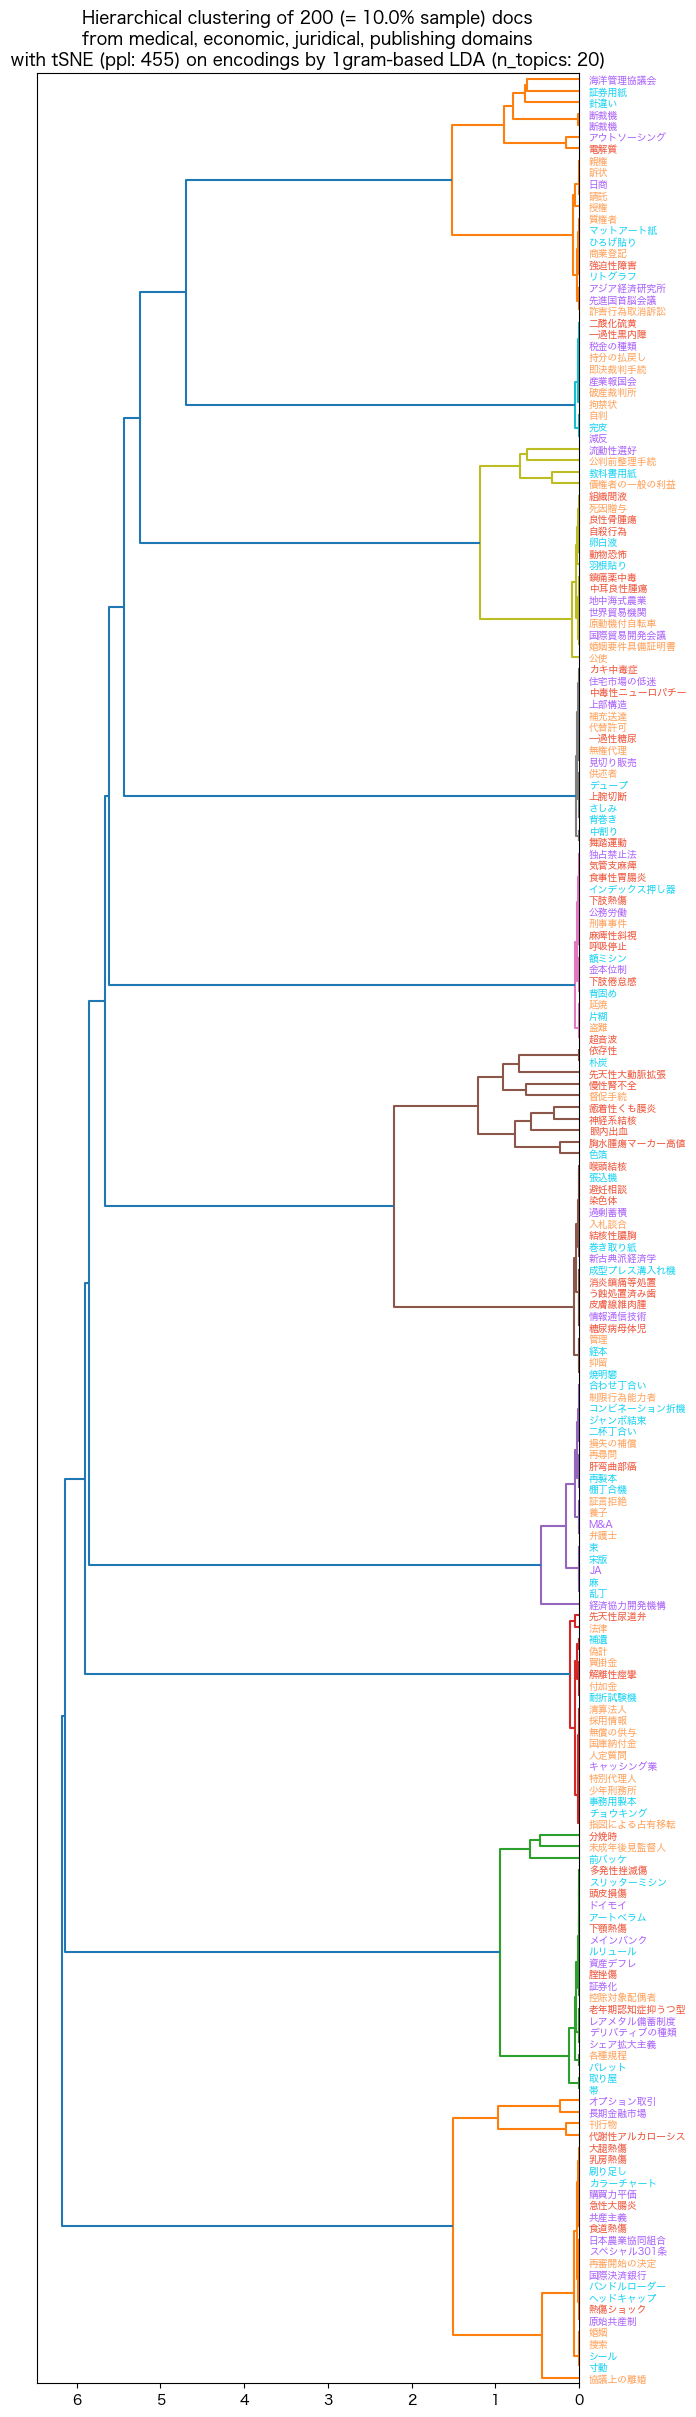

In [20]:
## doc 階層クラスタリングの実行

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成

## 生データから
doc_linkage_plain = linkage(list(df_sampled['enc']), method = 'ward', metric = 'euclidean')

import numpy as np
import plotly
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定

## 描画サイズの指定
plt.figure(figsize = (7, round(10 * len(df_sampled) * 0.015))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_size = max_doc_length
label_vals = [ x[:label_size] for x in list(df_sampled[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage_plain, orientation = 'left', labels = label_vals, leaf_font_size = 7)
plt.title(f"Hierarchical clustering of {len(df_sampled)} (= {100 * hc_sampling_rate}% sample) docs\n\
from {', '.join(selected_domains.keys())} domains\n\
with tSNE (ppl: {perplexity_val}) on encodings by {term_type}-based LDA (n_topics: {n_topics})")

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    row = df_sampled.loc[df_sampled[doc_type] == word]
    try:
        did = int(row['domain_id'])
    except TypeError:
        #print(row)
        pass
    ticker.set_color(plotly.colors.qualitative.Plotly[did + 1]) # did の基数調整
#
plt.show()